In [0]:
# !pip install tensorflow==1.15.0

In [0]:
# !pip install keras==2.0.8

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.0
2.0.8


In [4]:
import tensorflow as tf

print(tf.test.is_gpu_available())

True


In [5]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
cd gdrive/My Drive/Colab Notebooks/Food Recognition

/content/gdrive/My Drive/Colab Notebooks/Food Recognition


# Food Recognition

## About the Ddtaset

## Purpose of the challenge

### Quick Process
- 

In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
import itertools
from sklearn.model_selection import KFold

import pandas

In [0]:
# define a path
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset'
ROOT_DIR = '/content/gdrive/My Drive/Colab Notebooks/Food Recognition'

In [9]:
pwd

'/content/gdrive/My Drive/Colab Notebooks/Food Recognition'

In [0]:
train_dir = os.path.join(DATA_DIR, 'train')
test_dir = os.path.join(DATA_DIR, 'val')

## Step 1: Clone the Mask R-CNN repository


Install Matterport's Mask-RCNN model from github.

https://github.com/matterport/Mask_RCNN

In [11]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.



## Step 2: Download the pre-trained weights for COCO model from MatterPort.


In [12]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw------- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


## Step3 : Import the required libraries

In [0]:
# import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import numpy as np

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

load json file annotaions

In [0]:
with open(train_dir+'/annotations.json') as file:
    json_data = json.load(file)

In [15]:
print(len(json_data))

4


In [16]:
dict(itertools.islice(json_data.items(),3))

{'categories': [{'id': 2578,
   'name': 'water',
   'name_readable': 'Water',
   'supercategory': 'food'},
  {'id': 2939,
   'name': 'pizza-margherita-baked',
   'name_readable': 'Pizza, Margherita, baked',
   'supercategory': 'food'},
  {'id': 1085,
   'name': 'broccoli',
   'name_readable': 'Broccoli',
   'supercategory': 'food'},
  {'id': 1040,
   'name': 'salad-leaf-salad-green',
   'name_readable': 'Salad, leaf / salad, green',
   'supercategory': 'food'},
  {'id': 1070,
   'name': 'zucchini',
   'name_readable': 'Zucchini',
   'supercategory': 'food'},
  {'id': 2022, 'name': 'egg', 'name_readable': 'Egg', 'supercategory': 'food'},
  {'id': 2053,
   'name': 'butter',
   'name_readable': 'Butter',
   'supercategory': 'food'},
  {'id': 1566,
   'name': 'bread-white',
   'name_readable': 'Bread, white',
   'supercategory': 'food'},
  {'id': 1151,
   'name': 'apple',
   'name_readable': 'Apple',
   'supercategory': 'food'},
  {'id': 2131,
   'name': 'dark-chocolate',
   'name_readable

In [17]:
json_data.keys()

dict_keys(['categories', 'info', 'images', 'annotations'])

In [18]:
# food categories
print(type(json_data['categories']))
print(len(json_data['categories']))

<class 'list'>
61


In [19]:
json_data['categories'][:10]

[{'id': 2578,
  'name': 'water',
  'name_readable': 'Water',
  'supercategory': 'food'},
 {'id': 2939,
  'name': 'pizza-margherita-baked',
  'name_readable': 'Pizza, Margherita, baked',
  'supercategory': 'food'},
 {'id': 1085,
  'name': 'broccoli',
  'name_readable': 'Broccoli',
  'supercategory': 'food'},
 {'id': 1040,
  'name': 'salad-leaf-salad-green',
  'name_readable': 'Salad, leaf / salad, green',
  'supercategory': 'food'},
 {'id': 1070,
  'name': 'zucchini',
  'name_readable': 'Zucchini',
  'supercategory': 'food'},
 {'id': 2022, 'name': 'egg', 'name_readable': 'Egg', 'supercategory': 'food'},
 {'id': 2053,
  'name': 'butter',
  'name_readable': 'Butter',
  'supercategory': 'food'},
 {'id': 1566,
  'name': 'bread-white',
  'name_readable': 'Bread, white',
  'supercategory': 'food'},
 {'id': 1151,
  'name': 'apple',
  'name_readable': 'Apple',
  'supercategory': 'food'},
 {'id': 2131,
  'name': 'dark-chocolate',
  'name_readable': 'Dark chocolate',
  'supercategory': 'food'}]

In [20]:
print(type(json_data['info']))
print(len(json_data['info']))
print(json_data['info'])

<class 'str'>
2
{}


In [21]:
print(type(json_data['images']))
print(len(json_data['images']))

<class 'list'>
7949


In [22]:
json_data['images'][: 10]

[{'file_name': '065561.jpg', 'height': 464, 'id': 65561, 'width': 464},
 {'file_name': '032796.jpg', 'height': 480, 'id': 32796, 'width': 480},
 {'file_name': '032797.jpg', 'height': 478, 'id': 32797, 'width': 478},
 {'file_name': '065574.jpg', 'height': 830, 'id': 65574, 'width': 831},
 {'file_name': '032808.jpg', 'height': 943, 'id': 32808, 'width': 943},
 {'file_name': '065581.jpg', 'height': 464, 'id': 65581, 'width': 464},
 {'file_name': '065587.jpg', 'height': 830, 'id': 65587, 'width': 831},
 {'file_name': '065594.jpg', 'height': 628, 'id': 65594, 'width': 628},
 {'file_name': '032845.jpg', 'height': 480, 'id': 32845, 'width': 480},
 {'file_name': '065615.jpg', 'height': 464, 'id': 65615, 'width': 464}]

In [23]:
print(type(json_data['annotations']))
print(len(json_data['annotations']))

<class 'list'>
11468


In [24]:
json_data['annotations'][:1]

[{'area': 40035.0,
  'bbox': [57.5, 138.5, 280.0, 173.0],
  'category_id': 2578,
  'id': 102450,
  'image_id': 65561,
  'iscrowd': 0,
  'segmentation': [[235.0,
    337.5,
    190.0,
    333.5,
    180.5,
    328.0,
    174.5,
    315.0,
    157.5,
    231.0,
    148.5,
    158.0,
    138.5,
    112.0,
    138.5,
    79.0,
    145.5,
    60.00000000000001,
    151.0,
    57.5,
    180.0,
    57.5,
    207.0,
    62.50000000000001,
    245.00000000000003,
    55.5,
    280.0,
    57.5,
    292.5,
    67.0,
    308.5,
    91.0,
    311.5,
    110.0,
    310.5,
    137.0,
    303.5,
    182.0,
    297.5,
    261.0,
    288.5,
    306.0,
    283.5,
    318.0,
    271.0,
    331.5,
    261.0,
    335.5]]}]

In [25]:
json_data['annotations'][0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

## Step 4: We Create a myMaskRCNNConfig class for training on the food dataset.


In [26]:
class FoodConfig(Config):
    """ Configuration for training food detection on the Food Recognition dataset.
    Overrides values in the base Config class.
    """

    NAME = 'food-challenge'

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    BACKBONE = 'resnet50'

    NUM_CLASSES = 62 # 61 food classes + background

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256


    STEPS_PER_EPOCH = 100

config = FoodConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Step 5: Build the custom food dataset.

In [0]:
class FoodDataset(utils.Dataset):
    def image_reference(self, image_id):
        """ 
        Return a reference for a particular image
        Ideally you this function is supposed to return a URL
        but in this case, we will simply return the image_id
        """
        return f'food-challenge : {image_id}'


    def load_dataset(self, dataset_dir, return_coco=True):
        # define path
        image_path = os.path.join(dataset_dir, 'images')
        annotation_path = os.path.join(dataset_dir, 'annotations.json')
        print('image_path-->', image_path)
        print('annotation_path-->', annotation_path)
        # assert os.path.exists(annotation_path) and os.path.exists(image_path)


        self.coco = COCO(annotation_path)
        self.image_path = image_path
        
        # load classes 
        class_ids = sorted(self.coco.getCatIds())
        print('-'*50)
        print('sorted class_ids -->',class_ids)
        class_ids = self.coco.getCatIds()
        print('class_ids -->', class_ids)
        print('class_ids_len -->', len(class_ids))


        # load images 
        image_ids = list(self.coco.imgs.keys())
        print('image_ids -->', image_ids)
        print('image_ids_len -->', len(image_ids))

        # add classes
        for i in class_ids:
            self.add_class('food-challenge', i, self.coco.loadCats(i)[0]['name'])


        # add images
        for i in image_ids:
            # assert(os.path.exists(os.path.join(image_path, self.coco.imgs[i]['file_name'])))

            self.add_image(
                'food-challenge', image_id=i,
                path=os.path.join(image_path, self.coco.imgs[i]['file_name']),
                width=self.coco.imgs[i]['width'],
                height=self.coco.imgs[i]['height'],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_coco:
            return self.coco


    def load_mask(self, image_id):
        '''
        masks: A bool array of shape [height, width, instance count] with one mask per instance
        class_ids: a 1D array of class IDs of the instance masks

        '''
        image_info = self.image_info[image_id]
        assert image_info["source"] == "food-challenge"

        
        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]['annotations']

        # Build mask of shape [H, W, Instnace count] and list of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                'food-challenge.{}'.format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info['height'], image_info['width'])
                
                # some objects are so small that they're less than 1 pixel area and end up rounded out. skip those objects.

                if m.max() < 1:
                    continue

                instance_masks.append(m)
                class_ids.append(class_id)


        # pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2) # .astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # call super class to return an empty mask
            return super(FoodDataset, self).load_mask(image_id)
        

    def annToRLE(self, ann, height, width):
        '''
        Convert annotation witch can be polygons, uncompressed RLE to RLE.
        : return : binary masks (numpy 2D array)
        '''
        segmentation = ann['segmentation']
        if isinstance(segmentation, list):
            # polygon --> a single object might consist of multiple parts
            # we merge all parts into one mask rle  code
            rles = maskUtils.frPyObjects(segmentation, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segmentation['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segmentation, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle


    def annToMask(self, ann, height, width):
        '''
        Convert annotation which can be polygons, uncompressed RLS, or RLE to binary mask.
        : return --> binary mask (numpy 2D array)
        '''
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)

        return m

## Step 6: prepare the train set, validation/test set

In [28]:
# prepare the training dataset
dataset_train = FoodDataset()
dataset_train.load_dataset(dataset_dir='/content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset/train', return_coco=True)
dataset_train.prepare()

image_path--> /content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset/train/images
annotation_path--> /content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset/train/annotations.json
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
--------------------------------------------------
sorted class_ids --> [1010, 1013, 1022, 1026, 1032, 1040, 1056, 1058, 1060, 1061, 1068, 1069, 1070, 1078, 1085, 1108, 1116, 1151, 1154, 1163, 1180, 1210, 1220, 1307, 1310, 1311, 1323, 1352, 1468, 1505, 1520, 1554, 1556, 1565, 1566, 1588, 1788, 1879, 1893, 1967, 2022, 2053, 2099, 2103, 2131, 2388, 2498, 2504, 2512, 2521, 2530, 2578, 2580, 2618, 2620, 2634, 2711, 2738, 2750, 2939, 3080]
class_ids --> [2578, 2939, 1085, 1040, 1070, 2022, 2053, 1566, 1151, 2131, 2521, 1068, 1026, 2738, 1565, 2512, 1061, 1311, 1505, 1468, 1967, 1078, 1116, 1022, 2504, 1154, 1163, 2750, 1210, 2620, 1310, 1893, 1069, 1058, 1180, 2618, 1010, 1588, 1879, 3080, 2388, 1108, 1032, 2099

In [29]:
# prepare the validataion dataset
dataset_val = FoodDataset()
dataset_val.load_dataset(dataset_dir='/content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset/val', return_coco=True)
dataset_val.prepare()

image_path--> /content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset/val/images
annotation_path--> /content/gdrive/My Drive/Colab Notebooks/Food Recognition/dataset/val/annotations.json
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
--------------------------------------------------
sorted class_ids --> [1010, 1013, 1022, 1026, 1032, 1040, 1056, 1058, 1060, 1061, 1068, 1069, 1070, 1078, 1085, 1108, 1116, 1151, 1154, 1163, 1180, 1210, 1220, 1307, 1310, 1311, 1323, 1352, 1468, 1505, 1520, 1554, 1556, 1565, 1566, 1588, 1788, 1879, 1893, 1967, 2022, 2053, 2099, 2103, 2131, 2388, 2498, 2504, 2512, 2521, 2530, 2578, 2580, 2618, 2620, 2634, 2711, 2738, 2750, 2939, 3080]
class_ids --> [2578, 2939, 1085, 1040, 1070, 2022, 2053, 1566, 1151, 2131, 2521, 1068, 1026, 2738, 1565, 2512, 1061, 1311, 1505, 1468, 1967, 1078, 1116, 1022, 2504, 1154, 1163, 2750, 1210, 2620, 1310, 1893, 1069, 1058, 1180, 2618, 1010, 1588, 1879, 3080, 2388, 1108, 1032, 2099, 25

## Step 7: Image Augmentation

image_shape --> (479, 479, 3)


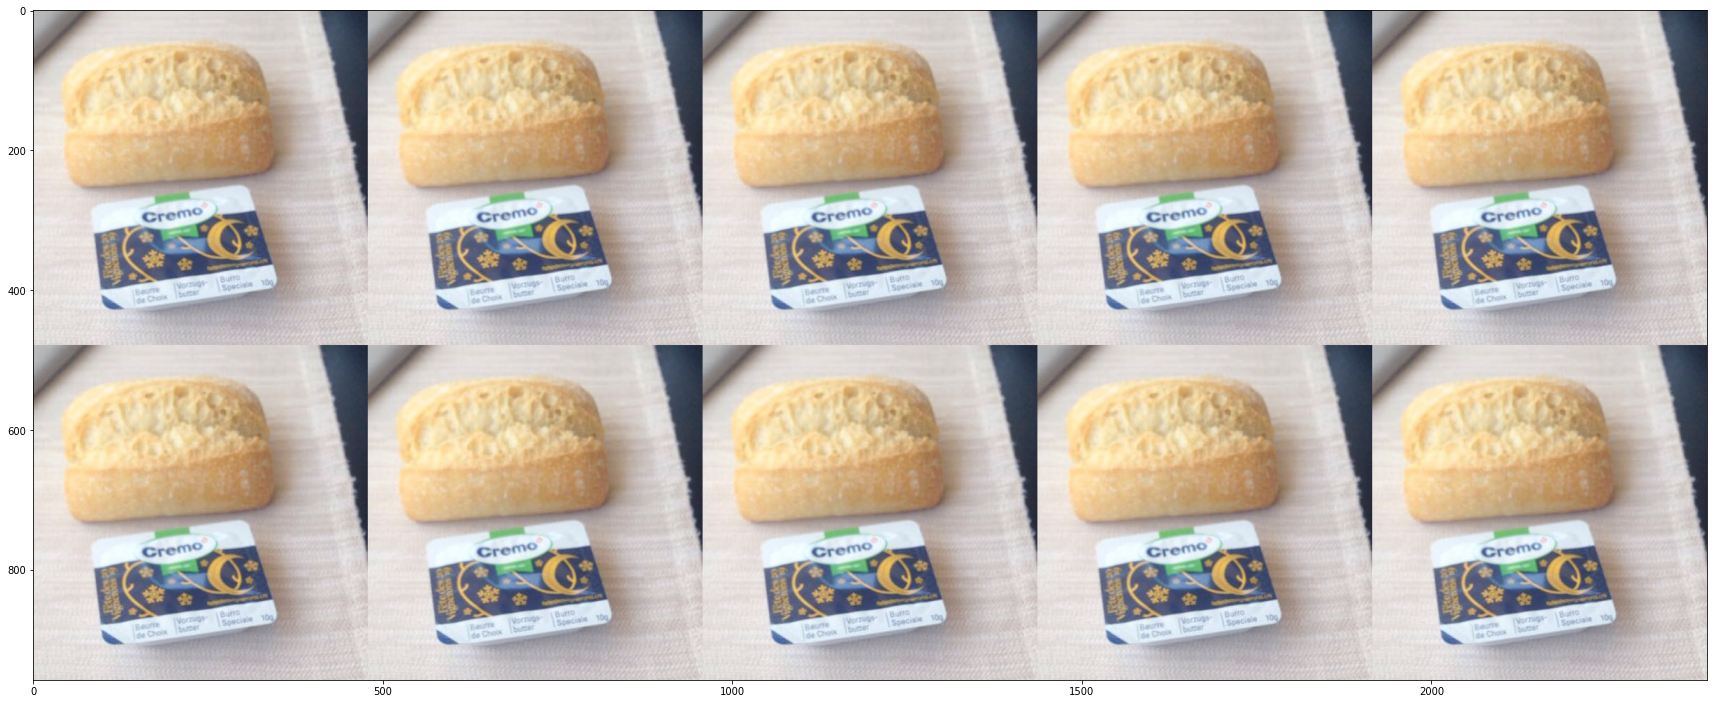

In [30]:
augmentation = iaa.SomeOf((0.1), [
        iaa.Fliplr(0.9), 
        iaa.Affine(
            scale={'x':(0.8, 1.2), 'y':(0.8, 1.2)},
            translate_percent = {'x':(-0.2, 0.2), 'y': (-0.2, 0.2)},
            rotate = (-20, 20),
            shear = (-10, 10)),
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1))
])

image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
print('image_shape -->', image.shape)

# test on the same image as above
aug_imgs = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 15))
plt.imshow(aug_imgs)

check the original images and masked things.

(830, 831, 3)

*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



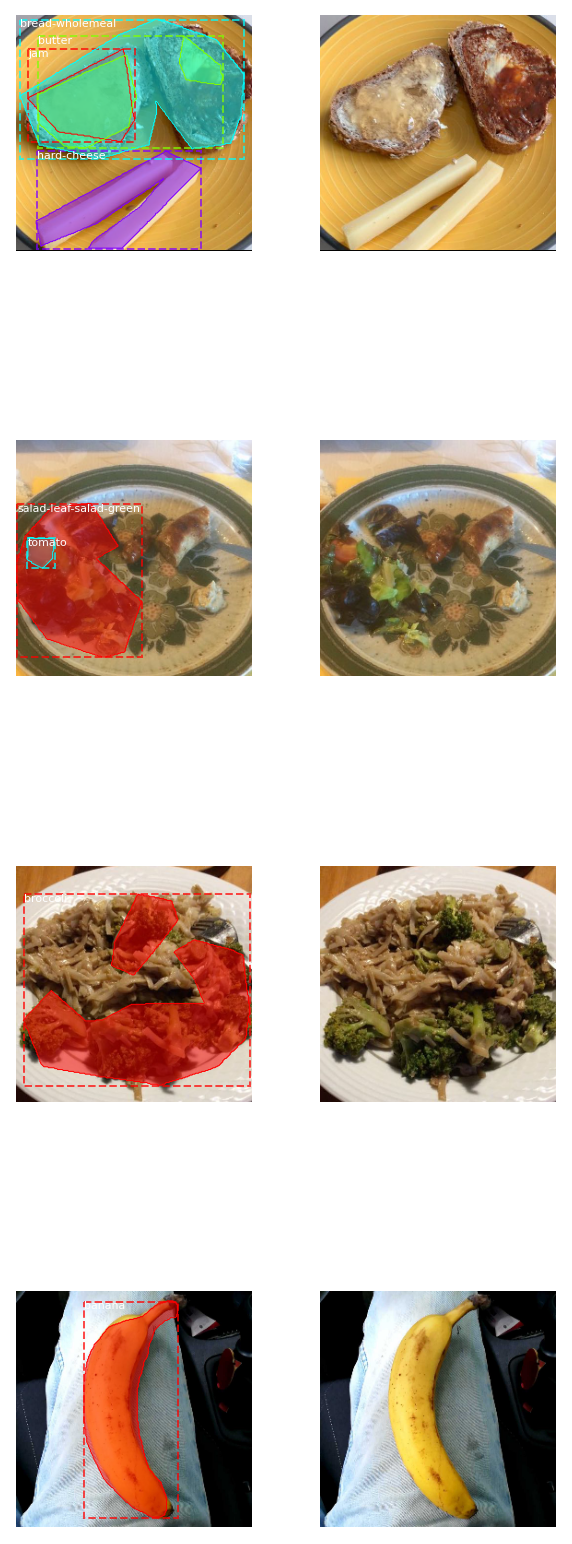

In [80]:
image = dataset_train.load_image(image_id)
fig = plt.figure(figsize=(10,30))

print(image.shape)

for i in range(4):    
    image_id = random.choice(dataset_train.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, FoodConfig, 
                               image_id, use_mini_mask=False)
    
    plt.subplot(4, 2, 2*i+1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, ax=fig.axes[-1])
    
    plt.subplot(4, 2, 2*i+2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], ax=fig.axes[-1])

## Step 8 :Initialize Mask R-CNN model for “training” using the Config instance that we created

In [31]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## Step 9: Load the pre-trained weights for the Mask R-CNN from COCO data set excluding the last few layers

In [32]:
# exclude the last layers because they require a matching number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [0]:
# Train mask rcnn model
import warnings
warnings.filterwarnings('ignore')

## Step 10: Train the heads with higher learning rate to speed up the learning

In [34]:
print('training now...')
model.train(dataset_train, dataset_val,
            learning_rate = config.LEARNING_RATE*2, epochs=2, layers='heads', augmentation=None)

history = model.keras_model.history.history

training now...

Starting at epoch 0. LR=0.002

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1547/mask_rcnn_food-challenge_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeD

In [35]:
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=15, layers='all', augmentation=augmentation)


Starting at epoch 2. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1547/mask_rcnn_food-challenge_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchN

In [0]:
new_history = model.keras_model.history.history

In [81]:
epochs = range(1, len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.234999,0.024318,0.56083,0.353035,0.631483,0.665331,2.943551,0.042396,0.849823,0.574384,0.767941,0.709006
2,2.113649,0.031064,0.45888,0.384898,0.607665,0.631141,2.191957,0.035040,0.592298,0.335828,0.575047,0.653743


In [38]:
best_epoch = np.argmin(history['val_loss'])
print('best epoch :', best_epoch +1, history['val_loss'][best_epoch])

best epoch : 2 2.1136487698554993


## Step 11: Select the trained model

In [40]:
# select trained model
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        f'Could not find model directory under {self.model_dir}')
    
fps = []

# pick last directory
for d in dir_names:
    dir_name = os.path.join(model.model_dir, d)

    # find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith('mask_rcnn'), checkpoints)
    checkpoints = sorted(checkpoints)

    if not checkpoints:
        print(f'No weight files in {dir_name}')
    
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print(f'Found model {model_path}')

No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1151
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1200
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1210
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1218
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1220
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1337
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1339
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1347
No weight files in /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1350
No weight files in /content/gdrive/My Drive/Colab Noteb

## Step 12: Define InferenceConfig and Load trained weights

In [41]:
class InferenceConfig(FoodConfig):
    """ Configuration for training food detection on the Food Recognition dataset.
    Overrides values in the base Config class.
    """

    NAME = 'food'

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256


config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [43]:
# recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', config=config, model_dir=ROOT_DIR)

# load trained weights
assert model_path != '', 'Provide path to trained weights'
print('loading weights from', model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
loading weights from /content/gdrive/My Drive/Colab Notebooks/Food Recognition/food-challenge20200506T1547/mask_rcnn_food-challenge_0001.h5
Re-starting from epoch 1


## Step 13: Visualize the results

(949, 949, 3)
(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 74)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32

*** No instances to display *** 

(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -112.80000  max:  151.10000  float64
image_metas              shape: (1, 74)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32

*** No instances to display *** 

(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         

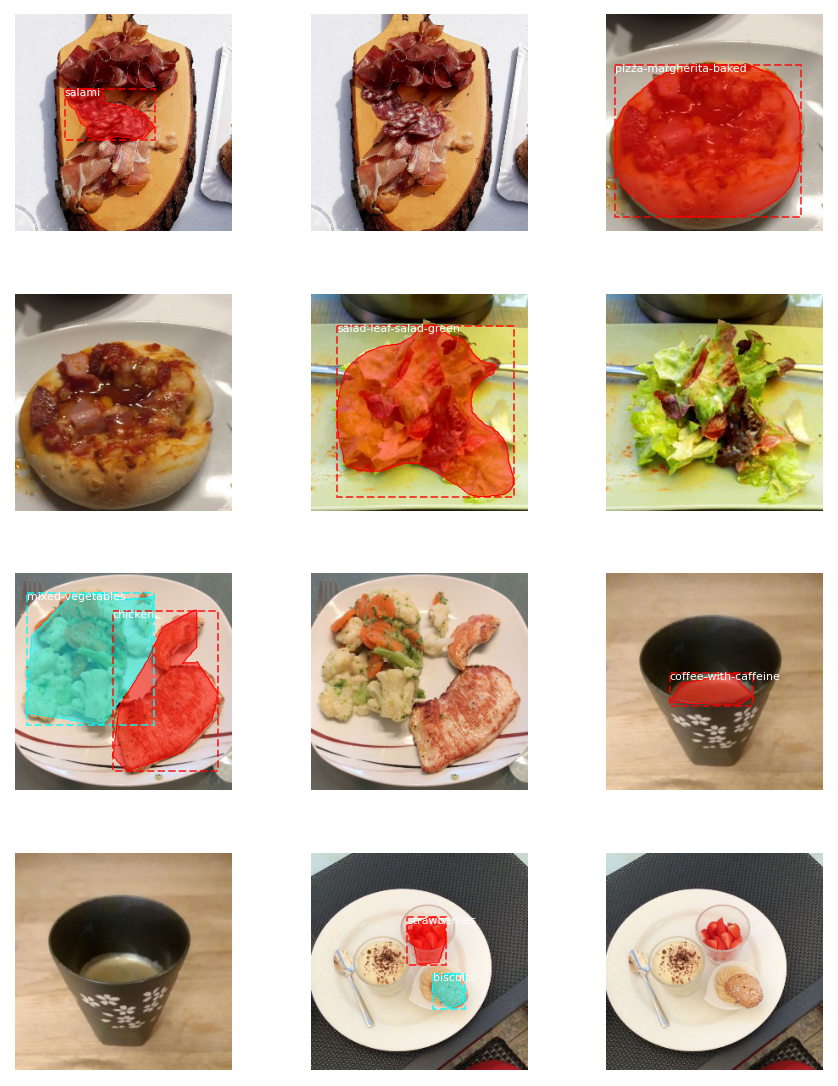

In [79]:
dataset = dataset_val
fig = plt.figure(figsize=(15, 30))

print(image.shape)

for i in range(6):
    image_id = random.choice(dataset_val.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 3, 2*i+1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 3, 2*i+2)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=fig.axes[-1])